**Final codes**

2021103799 章程程

**读取数据**

加载包并读取数据，查看数据结构

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #导入matplotlib.pyplot画图模块并命名为plt
import seaborn as sns    #导入seaborn画图模块并命名为sns
sns.set_theme(style='ticks')  #设置绘图风格为ticks
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [24]:
dt = pd.read_excel('foods.xlsx',sheet_name=0)

In [25]:
dt.columns

Index(['证券代码', '证券简称', '企业规模', '员工总数', '省份', '参考总市值', '主营产品名称', '主营产品类型',
       '总资产净利率-不含少数股东损益 %', '净资产收益率%', '销售净利率 %', '营业利润/营业总收入 %', '流动比率',
       '速动比率', '现金比率', '净利润(同比增长率) %', '净资产(同比增长率) %', '总资产(同比增长率)%',
       '基本每股收益(同比增长率) %', '存货周转率 ', '流动资产周转率', '总资产周转率', '应付账款周转率', '上市板'],
      dtype='object')

**定义类及捕获异常**

定义类进行缺失值判断,如果有类出现缺失值，就说明需要进行后续缺失值插补

In [33]:
class DtPreprocess:
    def __init__(self,x):
        self.dt = x
    def get_nan(self):
        y = pd.DataFrame(self.dt)
        for i in y.columns:
            if y[i].isnull().any():
                print('该列出现缺失值：'+i)
                raise Exception('出现缺失值')

In [34]:
dt1 = DtPreprocess(dt)

In [35]:
dt1.get_nan()

该列出现缺失值：应付账款周转率


Exception: 出现缺失值

**描述性统计**

由于缺失值不影响描述性统计，因此我们直接先对原始数据进行描述

In [39]:
#公司所在地分布图
df_sf = dt[['证券代码','省份']].groupby('省份').count().reset_index()
df_sf.省份.astype('str')

from pyecharts.charts import Map
from pyecharts import options as opts
provinces = df_sf.省份.map(lambda x: x[0:2] if ((len(x) >4) or (len(x)==2)) else x[0:-1])  #去掉省、自治区等字，只保留简称
provinces = provinces.values.tolist()
value = df_sf.证券代码.values.tolist()

# 绘制地图
c = (Map()
    .add("", [list(z) for z in zip(provinces, value)],'china')
    .set_global_opts(title_opts=opts.TitleOpts(title='公司所在地分布'),
                     visualmap_opts=opts.VisualMapOpts(max_= 25,min_=1,
                                                       range_color=["#E0ECF8", "#045FB4"])))
c.render_notebook()

Text(0.5, 1.0, '员工数量分布')

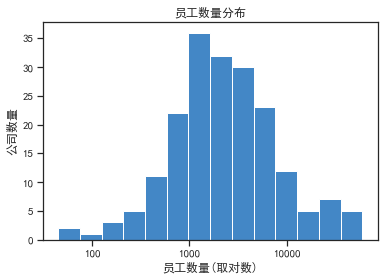

In [38]:
#员工数
sns.histplot(np.log(dt['员工总数']), color="#045FB4")
plt.xticks(ticks=np.log([100,1000,10000]),labels=['100','1000','10000'])
plt.xlabel('员工数量(取对数)')
plt.ylabel('公司数量')
plt.title('员工数量分布')

([<matplotlib.axis.XTick at 0x18573a788e0>,
 [Text(2.302585092994046, 0, '十亿'),
  Text(4.605170185988092, 0, '百亿'),
  Text(6.907755278982137, 0, '千亿'),
  Text(9.210340371976184, 0, '万亿')])

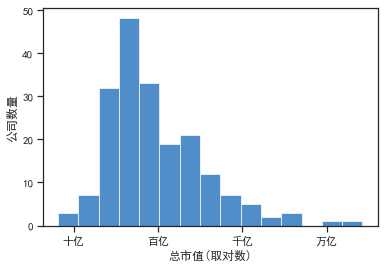

In [34]:
#公司市值
dat_sz = dt.sort_values(by = '参考总市值')['参考总市值'][0:-1]

plt.hist(np.log(dt['参考总市值']/100000000),bins=15,color="#045FB4",alpha=0.7)  #以亿为单位44
plt.xlabel('总市值(取对数)')
plt.ylabel('公司数量')
plt.xticks(ticks=np.log([10,100,1000,10000]),labels=['十亿','百亿','千亿','万亿'])

Text(0.5, 1.0, '员工数量分布')

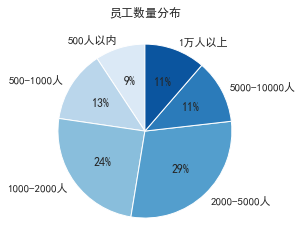

In [49]:
# 对员工数量分类后制作饼图
dat_gm = pd.cut(dt['员工总数'],[0,500,1000,2000,5000,10000,121995]).value_counts(sort=False)
labels = ['500人以内','500-1000人','1000-2000人','2000-5000人','5000-10000人','1万人以上']
plt.pie(dat_gm.values, labels =labels,startangle=90, colors = sns.color_palette("Blues", 6),autopct='%d%%')
plt.title('员工数量分布')

Text(0.5, 1.0, '企业规模')

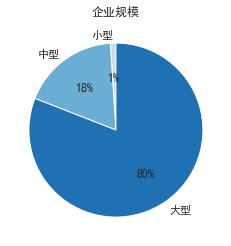

In [50]:
# 企业规模饼图
gm = dt['企业规模'].value_counts(ascending=True)
plt.pie(gm.values, labels =gm.keys(),startangle=90, colors = sns.color_palette("Blues", 3),autopct='%d%%')
plt.title('企业规模')

**处理异常**——插补缺失值

在进行建模分析前，需要对缺失值进行处理。
这里采用k近邻法插补缺失值

In [12]:
from sklearn.impute import KNNImputer

In [21]:
imputer = KNNImputer(n_neighbors=5)
dt1=dt.iloc[:,8:23]
dt1_k =  pd.DataFrame(imputer.fit_transform(dt1))

In [22]:
type(dt1_k)

pandas.core.frame.DataFrame

In [23]:
dt2 = dt.iloc[:,[1]]
df_p = pd.concat([dt2,dt1_k],axis=1)

**因子分析**

In [24]:
#加载必要的包
from scipy.stats import bartlett
from factor_analyzer import *
import numpy.linalg as nlg
from sklearn.cluster import KMeans
from matplotlib import cm

先进行相关性检验

In [25]:
#巴特雷特球度检验
df_f = df_p.iloc[:,1:21]
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity,calculate_kmo
chi_square_value, p_value = calculate_bartlett_sphericity(df_f)
chi_square_value,p_value

(2659.195024589433, 0.0)

In [30]:
#KMO检验
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all, kmo_model = calculate_kmo(df_f)
print(kmo_model)

0.6372868155261527


通过碎石图寻找合适的因子数

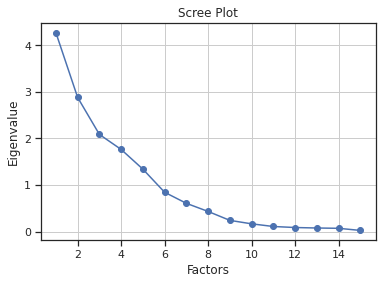

In [26]:
fa = FactorAnalyzer(25,rotation=None)
fa.fit(df_f)

ev,v = fa.get_eigenvalues()


# 可视化
# plot横轴是指标个数，纵轴是ev值
# scatter横轴是指标个数，纵轴是ev值

plt.scatter(range(1,df_f.shape[1]+1),ev)
plt.plot(range(1,df_f.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

根据特征根大于一原则，确定是五个因子

In [27]:
fa = FactorAnalyzer(5, rotation="varimax")
fa.fit(df_f)

# # 15*5(变量个数*因子个数)
fa.loadings_

array([[ 0.13475752,  0.93605646,  0.07564799,  0.08310617,  0.18809244],
       [-0.05003892,  0.75261596,  0.07779944, -0.07243974,  0.06803266],
       [ 0.1480156 ,  0.93900986, -0.02989404,  0.06453452,  0.09552514],
       [ 0.27612414,  0.50933658, -0.12070543,  0.27463169,  0.12823827],
       [ 0.92435396,  0.10801538, -0.12932945, -0.00256972,  0.08254788],
       [ 0.98465521,  0.10640975, -0.06159078,  0.00350873,  0.12584885],
       [ 0.93648579,  0.11816336, -0.07739918,  0.02661889,  0.1805804 ],
       [ 0.00479231,  0.0274997 , -0.02948542,  0.94588161,  0.00685334],
       [ 0.20180827,  0.18859883,  0.02445336,  0.01606922,  0.80887262],
       [ 0.1256356 ,  0.17821647,  0.07262657, -0.00924702,  0.92946124],
       [ 0.00322909,  0.10415419, -0.01260379,  0.94331467, -0.00406061],
       [ 0.07231756, -0.09470196,  0.51550468,  0.06683077,  0.1738434 ],
       [-0.30258427,  0.0376046 ,  0.88500349, -0.02383389,  0.07426197],
       [-0.18561416,  0.13984731,  0.8

因子分析结果可视化——热力图

Text(86.5, 0.5, '变量')

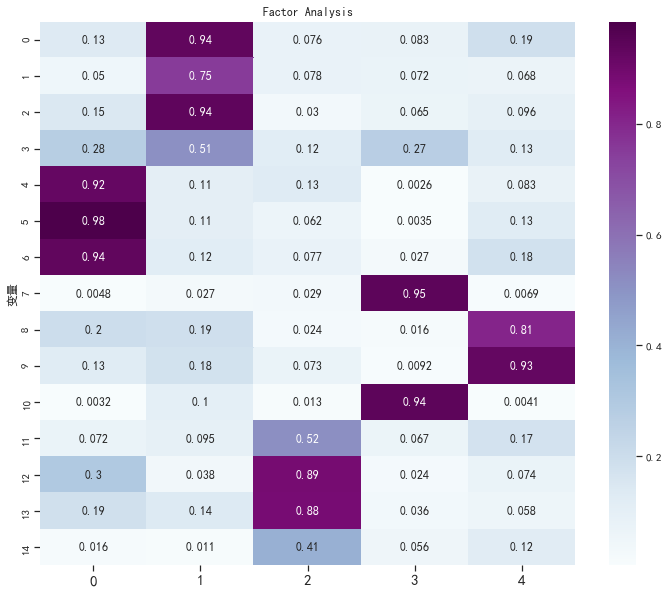

In [35]:
import seaborn as sns
df_cm = pd.DataFrame(np.abs(fa.loadings_),index=df_f.columns)

fig,ax = plt.subplots(figsize=(12,10))
sns.heatmap(df_cm,annot=True,cmap='BuPu',ax=ax)
# 设置y轴字体的大小
ax.tick_params(axis='x',labelsize=15)
ax.set_title("Factor Analysis",fontsize=12)
ax.set_ylabel("变量")

转换原始数据变量，计算各样本在各因子上的得分

In [42]:
df_c = pd.DataFrame(fa.transform(df_f))

**聚类分析**

In [40]:
from scipy.cluster.hierarchy import linkage, dendrogram

In [45]:
X = linkage(df_c, method='average', metric='euclidean')

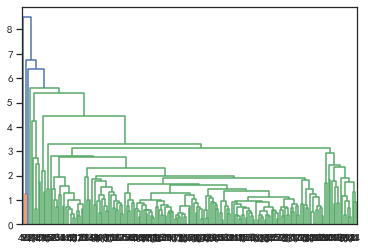

In [46]:
dendrogram(X,leaf_rotation=0,leaf_font_size=10)
plt.show()